# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [2]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [3]:
# using SQLite Table to read data.
con = sqlite3.connect('dataset/database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 8000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return "negative"
    return "positive"

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (8000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [4]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [5]:
print(display.shape)
#display first five row
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B005ZBZLT4,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ESG,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B005ZBZLT4,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ESG,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBEV0,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [6]:
#display individual record based on particular user id
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B001ATMQK2,"undertheshrine ""undertheshrine""",1296691200,5,I bought this 6 pack because for the price tha...,5


In [7]:
#count number of records
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [8]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [9]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [10]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(7975, 10)

In [11]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

99.6875

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [12]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [13]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [14]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(7975, 10)


positive    6658
negative    1317
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [15]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

Why is this $[...] when the same product is available for $[...] here?<br />http://www.amazon.com/VICTOR-FLY-MAGNET-BAIT-REFILL/dp/B00004RBDY<br /><br />The Victor M380 and M502 traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.
Most of the time, you want crackers because you want to get the dip or whatever topping into your mouth! With these, you can have those snacks again without having to worry about the calorie content of your crackers!<br /><br />They're only 17 calories a slice, and each slice is about the size of a 3 x 5 notecard. They're delicate and have a nice easy "crunch." These ones in particular have a lower sodium content as well, versus the pesto and garlic ones (they're a bit higher in sodium content, over 200 mg per 3 slices).<br /><br />It's an excellent addition, no matter what diet you are on...or if you're not even on a diet! I bring them to parties and everyone always asks what they are and where can they get them.
Kettle Ch

In [16]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

Why is this $[...] when the same product is available for $[...] here?<br /> /><br />The Victor M380 and M502 traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.


In [17]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

Why is this $[...] when the same product is available for $[...] here? />The Victor M380 and M502 traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.
Most of the time, you want crackers because you want to get the dip or whatever topping into your mouth! With these, you can have those snacks again without having to worry about the calorie content of your crackers!They're only 17 calories a slice, and each slice is about the size of a 3 x 5 notecard. They're delicate and have a nice easy "crunch." These ones in particular have a lower sodium content as well, versus the pesto and garlic ones (they're a bit higher in sodium content, over 200 mg per 3 slices).It's an excellent addition, no matter what diet you are on...or if you're not even on a diet! I bring them to parties and everyone always asks what they are and where can they get them.
Kettle Chips are the best potato chip God has ever invented.  I give the Lord thanks every day for delivering unt

In [18]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [19]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

Kettle Chips are the best potato chip God has ever invented.  I give the Lord thanks every day for delivering unto me such an incredulously delicious blend of ginger and spice, a veritable cornucopia of flavor.  I have actually changed my diet to a strict regiment of the Spicy Thai & Sea Salt and Vinegar flavors, alternating days. I have already lost 5 lbs, not to mention the myriad of other health benefits I have been experiencing. Get your life back - with Kettle Chips.


In [20]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

Why is this $[...] when the same product is available for $[...] here?<br /> /><br />The Victor  and  traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.


In [21]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

Kettle Chips are the best potato chip God has ever invented I give the Lord thanks every day for delivering unto me such an incredulously delicious blend of ginger and spice a veritable cornucopia of flavor I have actually changed my diet to a strict regiment of the Spicy Thai Sea Salt and Vinegar flavors alternating days I have already lost 5 lbs not to mention the myriad of other health benefits I have been experiencing Get your life back with Kettle Chips 


In [22]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [23]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())


100%|██████████| 7975/7975 [00:04<00:00, 1763.06it/s]


In [24]:
preprocessed_reviews[1500]
final['preprocessed_reviews'] = preprocessed_reviews
final['preprocessed_reviews'].shape
final.shape

(7975, 11)

In [25]:
# store latest data in final.sqlite
conn = sqlite3.connect('final.sqlite')
c = conn.cursor()
conn.text_factory = str
final.to_sql('Reviews', conn, schema=None, if_exists='replace', index=True, index_label=None, chunksize=None, dtype=None)
print(final.shape)
conn = sqlite3.connect('./final.sqlite')
final = pd.read_sql_query("""
SELECT *
FROM Reviews
""", conn)

(7975, 11)


<h2><font color='red'>[3.2] Preprocessing Review Summary</font></h2>

In [26]:

#split data into train, cross validate and test 
%matplotlib inline
import warnings
from sklearn.model_selection import train_test_split
X = final['preprocessed_reviews']
Y = final['Score']

# train and test  split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.3, random_state=0)
X_tr, X_tes, Y_tr, Y_tes = train_test_split(X, Y, test_size=.3, random_state=0)


In [27]:
final.head(3)
print(final.shape)

(7975, 12)


# [4] Featurization

## [4.1] BAG OF WORDS

In [28]:
#BoW
#X_train,X_test,y_train,y_test = train_test_split(final['preprocessed_reviews'],final['Score'],test_size=0.3,random_state=0)
print(X_test.shape,Y_test.shape,X_train.shape,X_train.shape)
count_vect = CountVectorizer(ngram_range=(1,1)) #in scikit-learn
X_train = count_vect.fit_transform(X_train)
X_test = count_vect.transform(X_test)

# print("some feature names ", count_vect.get_feature_names()[:10])
# print('='*50)

# final_counts = count_vect.transform(preprocessed_reviews)
# print("the type of count vectorizer ",type(final_counts))
# print("the shape of out text BOW vectorizer ",final_counts.get_shape())
# print("the number of unique words ", final_counts.get_shape()[1])

(2393,) (2393,) (5582,) (5582,)


# Apply KNN 


In [29]:
from sklearn.neighbors import KNeighborsClassifier
#function for optimal K
def k_classifier_brute(X_train, y_train):
    # creating odd list of K for KNN
    myList = list(range(0,40))
    neighbors = list(filter(lambda x: x % 2 != 0, myList))

    # empty list that will hold cv scores
    cv_scores = []

    # perform 10-fold cross validation
    for k in neighbors:
        knn = KNeighborsClassifier(n_neighbors=k, algorithm = "brute")
        scores = cross_val_score(knn, X_train, y_train, cv=10, scoring='accuracy')
        cv_scores.append(scores.mean())

    # changing to misclassification error
    MSE = [1 - x for x in cv_scores]

    # determining best k
    optimal_k = neighbors[MSE.index(min(MSE))]
    print('\nThe optimal number of neighbors is %d.' % optimal_k)

    # plot misclassification error vs k 
    plt.plot(neighbors, MSE)

    for xy in zip(neighbors, np.round(MSE,3)):
        plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')
    plt.title("Misclassification Error vs K")
    plt.xlabel('Number of Neighbors K')
    plt.ylabel('Misclassification Error')
    plt.show()

    print("the misclassification error for each k value is : ", np.round(MSE,3))
    return optimal_k


The optimal number of neighbors is 35.


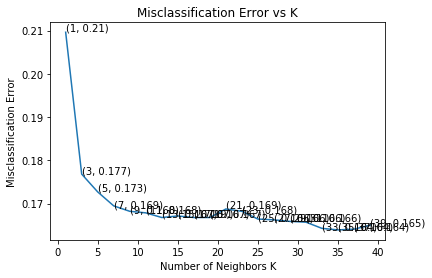

the misclassification error for each k value is :  [0.21  0.177 0.173 0.169 0.168 0.168 0.167 0.167 0.167 0.167 0.169 0.168
 0.166 0.166 0.166 0.166 0.164 0.164 0.164 0.165]
(2393, 13943)


In [30]:
#find optimal neighbors
# To choose optimal_k using brute force algorithm
from sklearn.model_selection import cross_val_score
from collections import Counter
from sklearn.metrics import accuracy_score

optimal_k_bow = k_classifier_brute(X_train,Y_train)
print(X_test.shape)


In [ ]:
optimal_model = KNeighborsClassifier(n_neighbors=optimal_k_bow,algorithm="brute")
optimal_model.fit(X_train, Y_train)
print(X_test.shape,Y_test.shape)
prediction = optimal_model.predict(X_test)

training_accuracy = optimal_model.score(X_train, Y_train)
training_error = 1 - training_accuracy
test_accuracy = accuracy_score(Y_test, prediction)
test_error = 1 - test_accuracy

print("_" * 101)
print("Training Accuracy: ", training_accuracy)
print("Train Error: ", training_error)
print("Test Accuracy: ", test_accuracy)
print("Test Error: ", test_error)
print("_" * 101)

(2393, 13943) (2393,)
_____________________________________________________________________________________________________
Training Accuracy:  0.8376925833034754
Train Error:  0.1623074166965246
Test Accuracy:  0.8399498537400752
Test Error:  0.16005014625992475
_____________________________________________________________________________________________________


## [4.2] Bi-Grams and n-Grams.

In [ ]:
#confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(Y_test, prediction)
cm

array([[  15,  372],
       [  11, 1995]])

In [ ]:
# plot confusion matrix to describe the performance of classifier.
import seaborn as sns
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [ ]:
#bi-gram, tri-gram and n-gram

#removing stop words like "not" should be avoided before building n-grams
# count_vect = CountVectorizer(ngram_range=(1,2))
# please do read the CountVectorizer documentation http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

# you can choose these numebrs min_df=10, max_features=5000, of your choice
count_vect = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=5000)
X_train_bow = count_vect.fit_transform(X_tr)
X_test_bow = count_vect.transform(X_tes)

print("the type of count vectorizer ",type(X_train_bow))
print("the shape of out text BOW vectorizer ",X_train_bow.get_shape())
print("the number of unique words including both unigrams and bigrams ", X_train_bow.get_shape()[1])
optimal_k = k_classifier_brute(X_train_bow,Y_tr)
optimal_model = KNeighborsClassifier(n_neighbors=optimal_k)
optimal_model.fit(X_train_bow, Y_tr)
print(X_test.shape,Y_test.shape)
prediction = optimal_model.predict(X_test_bow)

training_accuracy = optimal_model.score(X_train_bow, Y_tr)
training_error = 1 - training_accuracy
test_accuracy = accuracy_score(Y_tes, prediction)
test_error = 1 - test_accuracy

print("_" * 101)
print("Training Accuracy: ", training_accuracy)
print("Train Error: ", training_error)
print("Test Accuracy: ", test_accuracy)
print("Test Error: ", test_error)
print("_" * 101)

## [4.3] TF-IDF

In [ ]:
print(type(X_tr))
print(type(X_tes))
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
X_train_tf = count_vect.fit_transform(X_tr)
X_test_tf = count_vect.transform(X_tes)

print("the type of count vectorizer ",type(X_train_tf))
print("the shape of out text BOW vectorizer ",X_train_tf.get_shape())
print("the number of unique words including both unigrams and bigrams ", X_train_tf.get_shape()[1])
optimal_k = k_classifier_brute(X_train_tf,Y_tr)
optimal_model = KNeighborsClassifier(n_neighbors=optimal_k)
optimal_model.fit(X_train_tf, Y_tr)
print(X_test_tf.shape,Y_tes.shape)
prediction = optimal_model.predict(X_test_tf)

training_accuracy = optimal_model.score(X_train_tf, Y_tr)
training_error = 1 - training_accuracy
test_accuracy = accuracy_score(Y_tes, prediction)
test_error = 1 - test_accuracy

print("_" * 101)
print("Training Accuracy: ", training_accuracy)
print("Train Error: ", training_error)
print("Test Accuracy: ", test_accuracy)
print("Test Error: ", test_error)
print("_" * 101)

## [4.4] Word2Vec

In [ ]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentance=[]
for sentance in final['preprocessed_reviews']:
    list_of_sentance.append(sentance.split())

In [ ]:
want_to_train_w2v =True
if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model=Word2Vec(list_of_sentance,min_count=5,size=50, workers=4)
    w2v_word = list(w2v_model.wv.vocab)
    print(w2v_model.wv.most_similar('great'))
    print('='*50)
    print(w2v_model.wv.most_similar('worst'))
    


In [ ]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

## [4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V

#### [4.4.1.1] Avg W2v

In [ ]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))


In [ ]:
#train test split
from sklearn import preprocessing
X_tr_w,X_t_w,Y_tr_w,Y_t_w = train_test_split(sent_vectors,final['Score'],test_size=0.3,random_state=0)
train_avg_w2v = preprocessing.normalize(X_tr_w)
test_avg_w2v = preprocessing.normalize(X_t_w)
print(type(train_avg_w2v))
print(type(test_avg_w2v))

print("the type of count vectorizer ",type(train_avg_w2v))
#print("the shape of out text BOW vectorizer ",X_train_avg.get_shape())
#print("the number of unique words including both unigrams and bigrams ", X_train_avg.get_shape()[1])
optimal_k = k_classifier_brute(train_avg_w2v,Y_tr_w,algorithm="brute")
optimal_model = KNeighborsClassifier(n_neighbors=optimal_k)
optimal_model.fit(train_avg_w2v, Y_tr_w)
print(test_avg_w2v.shape,Y_tr_w.shape)
prediction = optimal_model.predict(test_avg_w2v)

training_accuracy = optimal_model.score(train_avg_w2v, Y_tr_w)
training_error = 1 - training_accuracy
test_accuracy = accuracy_score(Y_t_w, prediction)
test_error = 1 - test_accuracy

print("_" * 101)
print("Training Accuracy: ", training_accuracy)
print("Train Error: ", training_error)
print("Test Accuracy: ", test_accuracy)
print("Test Error: ", test_error)
print("_" * 101)

In [ ]:

optimal_k_avg = k_classifier_brute(train_avg_w2v,Y_tr_w,algorithm="brute")


#### [4.4.1.2] TFIDF weighted W2v

In [ ]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(preprocessed_reviews)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [ ]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

# [5] Assignment 3: KNN

<ol>
    <li><strong>Apply Knn(brute force version) on these feature sets</strong>
        <ul>
            <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ul>
    </li>
    <br>
    <li><strong>Apply Knn(kd tree version) on these feature sets</strong>
        <br><font color='red'>NOTE: </font>sklearn implementation of kd-tree accepts only dense matrices, you need to convert the sparse matrices of CountVectorizer/TfidfVectorizer into dense matices. You can convert sparse matrices to dense using .toarray() attribute. For more information please visit this <a href='https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.sparse.csr_matrix.toarray.html'>link</a>
        <ul>
            <li><font color='red'>SET 5:</font>Review text, preprocessed one converted into vectors using (BOW) but with restriction on maximum features generated.
            <pre>
            count_vect = CountVectorizer(min_df=10, max_features=500) 
            count_vect.fit(preprocessed_reviews)
            </pre>
            </li>
            <li><font color='red'>SET 6:</font>Review text, preprocessed one converted into vectors using (TFIDF) but with restriction on maximum features generated.
            <pre>
                tf_idf_vect = TfidfVectorizer(min_df=10, max_features=500)
                tf_idf_vect.fit(preprocessed_reviews)
            </pre>
            </li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ul>
    </li>
    <br>
    <li><strong>The hyper paramter tuning(find best K)</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>Find the best hyper paramter using k-fold cross validation or simple cross validation data</li>
    <li>Use gridsearch cv or randomsearch cv or you can also write your own for loops to do this task of hyperparameter tuning</li>
        </ul>
    </li>
    <br>
    <li>
    <strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure
    <img src='train_cv_auc.JPG' width=300px></li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='train_test_auc.JPG' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points
    <img src='confusion_matrix.png' width=300px></li>
        </ul>
    </li>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format. To print out a table please refer to this prettytable library<a href='http://zetcode.com/python/prettytable/'> link</a> 
        <img src='summary.JPG' width=400px>
    </li>
        </ul>
</ol>

<h4><font color='red'>Note: Data Leakage</font></h4>

1. There will be an issue of data-leakage if you vectorize the entire data and then split it into train/cv/test.
2. To avoid the issue of data-leakag, make sure to split your data first and then vectorize it. 
3. While vectorizing your data, apply the method fit_transform() on you train data, and apply the method transform() on cv/test data.
4. For more details please go through this <a href='https://soundcloud.com/applied-ai-course/leakage-bow-and-tfidf'>link.</a>

## [5.1] Applying KNN brute force

In [ ]:
# Please write all the code with proper documentation

### [5.1.2] Applying KNN brute force on TFIDF,<font color='red'> SET 2</font>

In [ ]:
# Please write all the code with proper documentation

### [5.1.3] Applying KNN brute force on AVG W2V,<font color='red'> SET 3</font>

In [ ]:
# Please write all the code with proper documentation

### [5.1.4] Applying KNN brute force on TFIDF W2V,<font color='red'> SET 4</font>

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
the type of count vectorizer  <class 'numpy.ndarray'>

The optimal number of neighbors is 25.


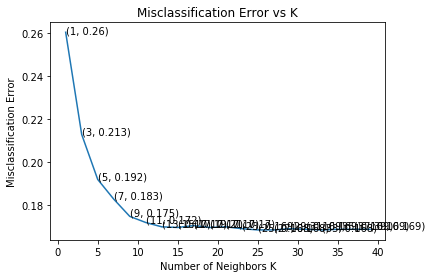

the misclassification error for each k value is :  [0.26  0.213 0.192 0.183 0.175 0.172 0.17  0.17  0.17  0.17  0.17  0.169
 0.168 0.168 0.169 0.169 0.168 0.169 0.169 0.169]
(1496, 50) (3490,)
_____________________________________________________________________________________________________
Training Accuracy:  0.8326647564469914
Train Error:  0.16733524355300855
Test Accuracy:  0.8536096256684492
Test Error:  0.14639037433155078
_____________________________________________________________________________________________________


In [77]:
# Please write all the code with proper documentation
#train test split
from sklearn import preprocessing
X_tr_w,X_t_w,Y_tr_w,Y_t_w = train_test_split(tfidf_sent_vectors,final['Score'],test_size=0.3,random_state=0)
train_avg_w2v = preprocessing.normalize(X_tr_w)
test_avg_w2v = preprocessing.normalize(X_t_w)
print(type(train_avg_w2v))
print(type(test_avg_w2v))

print("the type of count vectorizer ",type(train_avg_w2v))
#print("the shape of out text BOW vectorizer ",X_train_avg.get_shape())
#print("the number of unique words including both unigrams and bigrams ", X_train_avg.get_shape()[1])
optimal_k = k_classifier_brute(train_avg_w2v,Y_tr_w,algorithm="brute")
optimal_model = KNeighborsClassifier(n_neighbors=optimal_k)
optimal_model.fit(train_avg_w2v, Y_tr_w)
print(test_avg_w2v.shape,Y_tr_w.shape)
prediction = optimal_model.predict(test_avg_w2v)

training_accuracy = optimal_model.score(train_avg_w2v, Y_tr_w)
training_error = 1 - training_accuracy
test_accuracy = accuracy_score(Y_t_w, prediction)
test_error = 1 - test_accuracy

print("_" * 101)
print("Training Accuracy: ", training_accuracy)
print("Train Error: ", training_error)
print("Test Accuracy: ", test_accuracy)
print("Test Error: ", test_error)
print("_" * 101)


## [5.2] Applying KNN kd-tree

### [5.2.1] Applying KNN kd-tree on BOW,<font color='red'> SET 5</font>

/home/techgig/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/base.py:217: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: "
/home/techgig/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/base.py:217: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: "
/home/techgig/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/base.py:217: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: "
/home/techgig/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/base.py:217: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: "
/home/techgig/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/base.py:217: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with s

/home/techgig/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/base.py:217: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: "
/home/techgig/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/base.py:217: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: "
/home/techgig/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/base.py:217: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: "
/home/techgig/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/base.py:217: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: "
/home/techgig/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/base.py:217: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with s

/home/techgig/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/base.py:217: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: "
/home/techgig/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/base.py:217: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: "
/home/techgig/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/base.py:217: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: "
/home/techgig/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/base.py:217: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: "
/home/techgig/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/base.py:217: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with s

/home/techgig/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/base.py:217: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: "
/home/techgig/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/base.py:217: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: "
/home/techgig/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/base.py:217: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: "
/home/techgig/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/base.py:217: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: "
/home/techgig/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/base.py:217: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with s

/home/techgig/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/base.py:217: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: "
/home/techgig/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/base.py:217: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: "
/home/techgig/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/base.py:217: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: "
/home/techgig/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/base.py:217: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: "
/home/techgig/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/base.py:217: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with s


The optimal number of neighbors is 21.


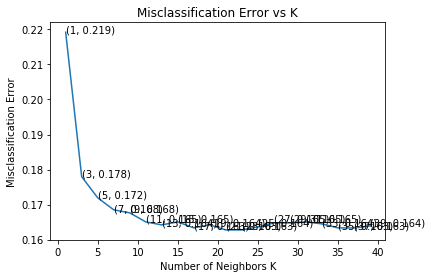

the misclassification error for each k value is :  [0.219 0.178 0.172 0.168 0.168 0.165 0.164 0.165 0.163 0.164 0.163 0.163
 0.164 0.165 0.165 0.165 0.164 0.163 0.163 0.164]
(1496, 10976) (1496,)
_____________________________________________________________________________________________________
Training Accuracy:  0.839541547277937
Train Error:  0.16045845272206305
Test Accuracy:  0.8536096256684492
Test Error:  0.14639037433155078
_____________________________________________________________________________________________________


In [78]:
optimal_k_bow = k_classifier_brute(X_train,Y_train,algorithm="kd_tree")
optimal_model = KNeighborsClassifier(n_neighbors=optimal_k_bow)
optimal_model.fit(X_train, Y_train)
print(X_test.shape,Y_test.shape)
prediction = optimal_model.predict(X_test)

training_accuracy = optimal_model.score(X_train, Y_train)
training_error = 1 - training_accuracy
test_accuracy = accuracy_score(Y_test, prediction)
test_error = 1 - test_accuracy

print("_" * 101)
print("Training Accuracy: ", training_accuracy)
print("Train Error: ", training_error)
print("Test Accuracy: ", test_accuracy)
print("Test Error: ", test_error)
print("_" * 101)   

### [5.2.2] Applying KNN kd-tree on TFIDF,<font color='red'> SET 6</font>

In [94]:
from sklearn.decomposition import TruncatedSVD
def k_classifier_kd_tree(X_train, y_train,X_test,algorithm,n_components=5):
    # creating odd list of K for KNN
    myList = list(range(0,40))
    neighbors = list(filter(lambda x: x % 2 != 0, myList))

    # empty list that will hold cv scores
    cv_scores = []
    svd = TruncatedSVD(n_components=n_components)
    X_train = svd.fit_transform(X_train)
    X_test = svd.fit_transform(X_test)

    # perform 10-fold cross validation
    for k in neighbors:
        knn = KNeighborsClassifier(n_neighbors=k, algorithm = algorithm)
        scores = cross_val_score(knn, X_train, y_train, cv=10, scoring='accuracy')
        cv_scores.append(scores.mean())

    # changing to misclassification error
    MSE = [1 - x for x in cv_scores]

    # determining best k
    optimal_k = neighbors[MSE.index(min(MSE))]
    print('\nThe optimal number of neighbors is %d.' % optimal_k)

    # plot misclassification error vs k 
    plt.plot(neighbors, MSE)

    for xy in zip(neighbors, np.round(MSE,3)):
        plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')
    plt.title("Misclassification Error vs K")
    plt.xlabel('Number of Neighbors K')
    plt.ylabel('Misclassification Error')
    plt.show()

    print("the misclassification error for each k value is : ", np.round(MSE,3))
    return optimal_k

In [95]:
X_train_tf,X_test_tf,y_train_tf,y_test_tf = train_test_split(tfidf_sent_vectors,final['Score'],test_size=0.3,random_state=20)
X_train_tf2 = preprocessing.normalize(X_train_tf)
X_test_tf2  = preprocessing.normalize(X_test_tf)


Text(0, 0.5, 'Cumulative wexplained variance')

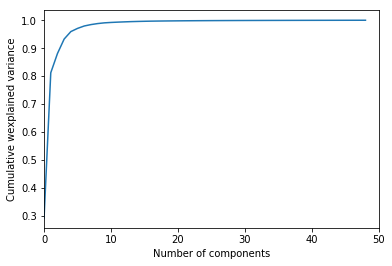

In [96]:

from sklearn.decomposition import TruncatedSVD
tsvd = TruncatedSVD(n_components=49).fit(X_test_tf2)
plt.plot(np.cumsum(tsvd.explained_variance_ratio_))
plt.xlim(0,50,10)
plt.xlabel('Number of components')
plt.ylabel('Cumulative wexplained variance')


The optimal number of neighbors is 15.


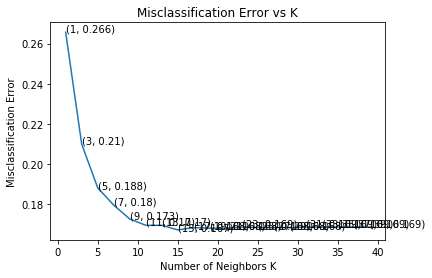

the misclassification error for each k value is :  [0.266 0.21  0.188 0.18  0.173 0.17  0.17  0.167 0.168 0.168 0.168 0.169
 0.168 0.168 0.168 0.169 0.169 0.169 0.169 0.169]
0.8522727272727273


In [106]:
#find optimal k using brute force
optimal_KNN_KD = k_classifier_kd_tree(X_train_tf2,y_train_tf,X_test_tf2,n_components=49,algorithm="kd_tree")
model_kd_tree = KNeighborsClassifier(n_neighbors=optimal_KNN_KD)
model_kd_tree.fit(X_train_tf2,y_train_tf)
prediction = model_kd_tree.predict(X_test_tf2)
accuracyscore = accuracy_score(prediction,y_test_tf)
print(accuracyscore)

The above model
### [5.2.3] Applying KNN kd-tree on AVG W2V,


The optimal number of neighbors is 29.


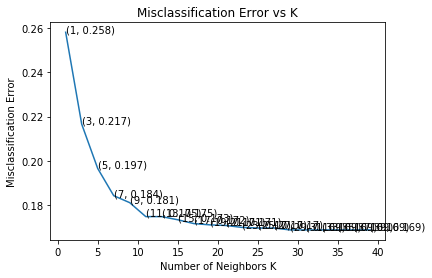

the misclassification error for each k value is :  [0.258 0.217 0.197 0.184 0.181 0.175 0.175 0.173 0.172 0.171 0.171 0.17
 0.17  0.17  0.169 0.169 0.169 0.169 0.169 0.169]
0.8522727272727273


In [109]:
# Please write all the code with proper documentation
X_train_w2v,X_test_w2v,y_train_w2v,y_test_w2v = train_test_split(sent_vectors,final['Score'],test_size=0.3,random_state=20)
X_train_w2v2 = preprocessing.normalize(X_train_w2v)
X_test_w2v2  = preprocessing.normalize(X_test_w2v)
optimal_kd_w2v = k_classifier_kd_tree(X_train_w2v2,y_train_w2v,X_test_w2v2,n_components=10,algorithm="kd_tree")
model_kd_avg_bow = KNeighborsClassifier(n_neighbors=optimal_kd_w2v)
model_kd_avg_bow.fit(X_train_w2v2,y_train_w2v)
prediction = model_kd_avg_bow.predict(X_test_w2v2)
accuracy = accuracy_score(prediction,y_test_w2v)
print(accuracy)


### [5.2.4] Applying KNN kd-tree on TFIDF W2V,<font color='red'> SET 4</font>

In [ ]:
# Please write all the code with proper documentation

# [6] Conclusions

In [ ]:
# Please compare all your models using Prettytable library